# Rede Neural (Neural Network)
## Table of Contents
* [Bibliotecas](#Bibliotecas-(Libraries))
* [Leitura dos Dados](#Leitura-dos-Dados)
* [Buscando os Melhores Hiperparâmetros](#Buscando-os-Melhores-Hiperparâmetros)
* [Rede Neural](#Rede-Neural)
* [Análise de Erro](#Análise-de-Erro)
* [Retreinando o Modelo](#Retreinando-o-Modelo)
* [Criando o Resultado](#Criando-o-Resultado-das-Previsões-para-Importar-ao-Kaggle)

## Bibliotecas (Libraries)

In [5]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=2)
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
tf.autograph.set_verbosity(1)
from skopt import gp_minimize

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

## Leitura dos Dados
Lendo o training e o test set, e conferindo as suas dimensões.

In [7]:
X_train_pre, X_test = pd.read_csv('../data/preprocessed/train.csv'), pd.read_csv('../data/preprocessed/test.csv')
print(f'Train set shape: {X_train_pre.shape}\nTest set shape: {X_test.shape}')

Train set shape: (891, 29)
Test set shape: (418, 28)


Lendo os 5 primeiros exemplos do training set.

In [9]:
X_train_pre.head()

,Sex_b,Age_pre,Pclass,Embarked_S,Embarked_C,SibSp,Parch,Fare,Cabin_null,Cabin_C,...,Name_Master,Name_Col,Name_Major,Name_Mr,Name_Dr,Name_Don,Name_Sir,Ticket_num,Ticket_cat,Survived
0,0,22.0,3,1,0,1,0,7.2500,1,0,...,0,0,0,1,0,0,0,21171,0,0
1,1,38.0,1,0,0,1,0,71.2833,0,1,...,0,0,0,1,0,0,0,17599,1,1
2,1,26.0,3,1,0,0,0,7.9250,1,0,...,0,0,0,0,0,0,0,3101282,2,1
3,1,35.0,1,1,0,1,0,53.1000,0,1,...,0,0,0,1,0,0,0,113803,3,1
4,0,35.0,3,1,0,0,0,8.0500,1,0,...,0,0,0,1,0,0,0,373450,4,0


Separando as features $X$ e o target $y$ para a criação do modelo.

In [11]:
y = X_train_pre['Survived'].copy()
X = X_train_pre.drop(columns=['Survived'], axis=1).copy()

## Buscando os Melhores Hiperparâmetros
Utilizando o método bayesian optimization para buscar os melhores hiperparâmetros para o modelo.

In [13]:
def fit_model(hparams):
    threshold = .5

    model = Sequential(
        [
            Input(shape=(X_opt.shape[1],)),
            Dense(units=128, activation='relu', name='L1', kernel_regularizer=l2(hparams[1])),
            Dense(units=64, activation='relu', name='L2', kernel_regularizer=l2(hparams[1])),
            Dense(units=32, activation='relu', name='L3', kernel_regularizer=l2(hparams[1])),
            Dense(units=16, activation='relu', name='L4', kernel_regularizer=l2(hparams[1])),
            Dense(units=1, activation='linear', name='L5')
        ],
        name='model'
    )
    
    model.compile(
        loss=BinaryCrossentropy(from_logits=True),
        optimizer=Adam(learning_rate=hparams[0]), 
        metrics=['accuracy']
    )
    
    model.fit(X_opt, y, epochs=100, verbose=0)
    
    yhat = model.predict(X_opt)
    yhat = tf.math.sigmoid(yhat)
    yhat = np.where(yhat >= threshold, 1, 0)
    acc = np.mean(yhat == y.to_numpy().reshape(-1, 1))
    
    
    return -acc

Definindo o espaço de cada hiperparâmetro para o modelo avaliar o desempenho do modelo em cada espaço de cada hiperparâmetro e retornando a melhor combinação, então, depois escalamos os dados, executamos a otimização dos hiperparâmetros e visualizamos a melhor combinação dos hiperparâmetros.

In [15]:
space = [
    (1e-6, 1e-1, 'log-uniform'), # learning_rate
    (1e-6, 1e-1), # lambda_r
]

X_opt = StandardScaler().fit_transform(X)
opt = gp_minimize(fit_model, space, random_state=42, verbose=0, n_calls=20, n_random_starts=5)
opt.x

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[0.0020986421291216886, 1e-06]

## Rede Neural
Criando, treinando o modelo no fold do training set e avaliando o modelo nos folds de training e dev set.

As avaliações no training e dev set estão sendo adicionadas em uma lista para depois serem plotadas.

In [17]:
LR = 1e-3
LAMBDA = 1e-2
THRESHOLD = 0.5

kf = RepeatedKFold(n_splits=2, n_repeats=2, random_state=42)
scaler = StandardScaler()

step_train = []
step_cv = []

for linhas_train, linhas_cv in kf.split(X):
    X_train, X_cv = X.iloc[linhas_train].copy(), X.iloc[linhas_cv].copy()
    y_train, y_cv = y[linhas_train], y[linhas_cv]

    X_train = scaler.fit_transform(X_train)
    X_cv = scaler.transform(X_cv)

    model = Sequential(
        [
            Input(shape=(X.shape[1],)),
            Dense(units=128, activation='relu', name='L1', kernel_regularizer=l2(LAMBDA)),
            Dense(units=64, activation='relu', name='L2', kernel_regularizer=l2(LAMBDA)),
            Dense(units=32, activation='relu', name='L3', kernel_regularizer=l2(LAMBDA)),
            Dense(units=16, activation='relu', name='L4', kernel_regularizer=l2(LAMBDA)),
            Dense(units=1, activation='linear', name='L5')
        ],
        name='model'
    )
    
    model.compile(
        loss=BinaryCrossentropy(from_logits=True),
        optimizer=Adam(learning_rate=LR), 
        metrics=['accuracy']
    )
    
    history = model.fit(
        X_train, y_train,
        epochs=200,
        verbose=0,
        validation_data=(X_cv, y_cv)
    )

    yhat_train = model.predict(X_train, verbose=0)
    yhat_cv = model.predict(X_cv, verbose=0)
    
    yhat_train = tf.math.sigmoid(yhat_train)
    yhat_train = np.where(yhat_train >= THRESHOLD, 1, 0)
    acc_train = np.mean(yhat_train == y_train.to_numpy().reshape(-1, 1))

    yhat_cv = tf.math.sigmoid(yhat_cv)
    yhat_cv = np.where(yhat_cv >= THRESHOLD, 1, 0)
    acc_cv = np.mean(yhat_cv == y_cv.to_numpy().reshape(-1, 1))

    step_train.append(acc_train)
    step_cv.append(acc_cv)

print(f'{"=" * 35}\n\nTrain mean: {np.mean(step_train):.2f}, CV mean: {np.mean(step_cv):.2f}')


Train mean: 0.93, CV mean: 0.82


Visualizando a arquitetura do modelo.

In [19]:
model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ L1 (Dense)                      │ (None, 128)            │         3,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L2 (Dense)                      │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L3 (Dense)                      │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L4 (Dense)                      │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L5 (Dense)                      │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,781 (171.02 KB)

 Trainable params: 14,593 (57.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,188 (114.02 KB)

Plotando o histórico do loss e da métrica de avaliação durante a última epoch de treinamento.

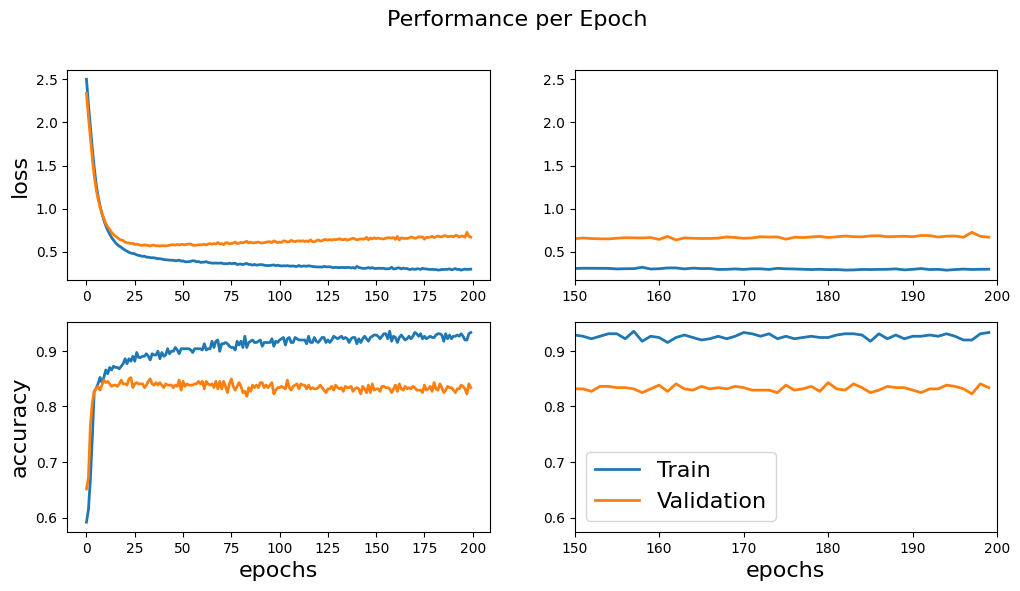

In [66]:
loss = history.history['loss']
val_loss = history.history['val_loss']
metric = history.history['accuracy']
val_metric = history.history['val_accuracy']
epochs = range(len(loss))
utils = [loss, 'loss'], [metric, 'accuracy']
val_utils = [val_loss], [val_metric]

fig, ax = plt.subplots(2, 2, figsize=(12, 6))
for i in range(2):
    fig.suptitle('Performance per Epoch', fontsize=16)
    ax[i, 0].plot(epochs, utils[i][0], label='Train', linewidth=2)
    ax[i, 0].plot(epochs, val_utils[i][0], label='Validation', linewidth=2)
    ax[i, 0].set_ylabel(utils[i][1], fontsize=16)        

    ax[i, 1].plot(epochs, utils[i][0], label='Train', linewidth=2)
    ax[i, 1].plot(epochs, val_utils[i][0], label='Validation', linewidth=2)
    ax[i, 1].set_xlim(int((len(utils[i][0]) * .75)), len(utils[i][0]))
    if i == 1:
        ax[i, 0].set_xlabel('epochs', fontsize=16)
        ax[i, 1].set_xlabel('epochs', fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.show()

Plotando o histórico do desempenho no training e no dev set.

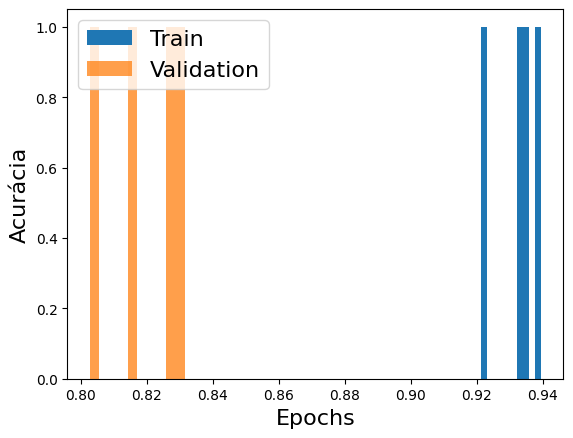

In [38]:
plt.hist(step_train, label='Train')
plt.hist(step_cv, label='Validation', alpha=.75)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Acurácia', fontsize=16)
plt.legend(loc='upper left', fontsize=16)
plt.grid(False)
plt.show()

Realizando a predição no test set.

In [64]:
X_test_pre = scaler.transform(X_test)
yhat = model.predict(X_test_pre, verbose=0)

## Análise de Erro
Executando a análise de erro nas previsões.

In [44]:
train = pd.read_csv('../data/raw/train.csv')
features = [c for c in X_train_pre.columns if c not in train.columns]
train = pd.concat([train, X_train_pre[features]], axis=1)

X_cv_erro = train.loc[linhas_cv].copy()
X_cv_erro['yhat'] = yhat_cv
X_cv_erro.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Name_Master,Name_Col,Name_Major,Name_Mr,Name_Dr,Name_Don,Name_Sir,Ticket_num,Ticket_cat,yhat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,1,0,0,0,21171,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,0,0,1,0,0,0,113803,3,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,1,0,0,0,373450,4,0
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,...,0,0,0,1,0,0,0,330877,5,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,...,0,0,0,1,0,0,0,17463,6,0


Definindo as previsões incorretas e, definindo e ordenando as features para leitura do dataset.

In [47]:
erro = X_cv_erro[X_cv_erro['Survived'] != X_cv_erro['yhat']]
erro = erro[['Survived', 'yhat', 'Name', 'Cabin', 'Embarked', 'Sex', 'Sex_b', 'Age', 'Age_pre', 'Pclass', 'Embarked_S',
             'Embarked_C', 'SibSp', 'Parch', 'Fare', 'Cabin_null',
             'Cabin_C', 'Cabin_E', 'Cabin_G', 'Cabin_D', 'Cabin_A', 'Cabin_B', 'Cabin_F', 'Cabin_T',
             'Name_Miss', 'Name_Mrs', 'Name_Master', 'Name_Col', 'Name_Major', 'Name_Mr', 'Name_Dr', 'Name_Don', 'Name_Sir']]
erro.head()

,Survived,yhat,Name,Cabin,Embarked,Sex,Sex_b,Age,Age_pre,Pclass,...,Cabin_T,Name_Miss,Name_Mrs,Name_Master,Name_Col,Name_Major,Name_Mr,Name_Dr,Name_Don,Name_Sir
7,0,1,"Palsson, Master. Gosta Leonard",NaN,S,male,0,2.0,2.0,3,...,0,0,0,1,0,0,0,0,0,0
10,1,0,"Sandstrom, Miss. Marguerite Rut",G6,S,female,1,4.0,4.0,3,...,0,1,0,0,0,0,0,0,0,0
14,0,1,"Vestrom, Miss. Hulda Amanda Adolfina",NaN,S,female,1,14.0,14.0,3,...,0,1,0,0,0,0,0,0,0,0
17,1,0,"Williams, Mr. Charles Eugene",NaN,S,male,0,NaN,29.0,2,...,0,0,0,0,0,0,1,0,0,0
25,1,0,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",NaN,S,female,1,38.0,38.0,3,...,0,0,1,0,0,0,1,0,0,0


Separando os erros entre a classe `male` e `female`.

In [50]:
female = erro[erro['Sex_b'] == 1]
male = erro[erro['Sex_b'] == 0]

Ordenando os erros da classe `female` pelo target $y$.

In [53]:
female.sort_values('Survived')

,Survived,yhat,Name,Cabin,Embarked,Sex,Sex_b,Age,Age_pre,Pclass,...,Cabin_T,Name_Miss,Name_Mrs,Name_Master,Name_Col,Name_Major,Name_Mr,Name_Dr,Name_Don,Name_Sir
14,0,1,"Vestrom, Miss. Hulda Amanda Adolfina",NaN,S,female,1,14.0,14.0,3,...,0,1,0,0,0,0,0,0,0,0
41,0,1,"Turpin, Mrs. William John Robert (Dorothy Ann ...",NaN,S,female,1,27.0,27.0,2,...,0,0,1,0,0,0,1,0,0,0
114,0,1,"Attalah, Miss. Malake",NaN,C,female,1,17.0,17.0,3,...,0,1,0,0,0,0,0,0,0,0
140,0,1,"Boulos, Mrs. Joseph (Sultana)",NaN,C,female,1,NaN,29.0,3,...,0,0,1,0,0,0,1,0,0,0
177,0,1,"Isham, Miss. Ann Elizabeth",C49,C,female,1,50.0,50.0,1,...,0,1,0,0,0,0,0,0,0,0
312,0,1,"Lahtinen, Mrs. William (Anna Sylfven)",NaN,S,female,1,26.0,26.0,2,...,0,0,1,0,0,0,1,0,0,0
404,0,1,"Oreskovic, Miss. Marija",NaN,S,female,1,20.0,20.0,3,...,0,1,0,0,0,0,0,0,0,0
852,0,1,"Boulos, Miss. Nourelain",NaN,C,female,1,9.0,9.0,3,...,0,1,0,0,0,0,0,0,0,0
772,0,1,"Mack, Mrs. (Mary)",E77,S,female,1,57.0,57.0,2,...,0,0,1,0,0,0,1,0,0,0
680,0,1,"Peters, Miss. Katie",NaN,Q,female,1,NaN,29.0,3,...,0,1,0,0,0,0,0,0,0,0


Ordenando os erros da classe `male` pelo target $y$.

In [56]:
male.sort_values('Survived')

,Survived,yhat,Name,Cabin,Embarked,Sex,Sex_b,Age,Age_pre,Pclass,...,Cabin_T,Name_Miss,Name_Mrs,Name_Master,Name_Col,Name_Major,Name_Mr,Name_Dr,Name_Don,Name_Sir
7,0,1,"Palsson, Master. Gosta Leonard",NaN,S,male,0,2.0,2.0,3,...,0,0,0,1,0,0,0,0,0,0
63,0,1,"Skoog, Master. Harald",NaN,S,male,0,4.0,4.0,3,...,0,0,0,1,0,0,0,0,0,0
139,0,1,"Giglio, Mr. Victor",B86,C,male,0,24.0,24.0,1,...,0,0,0,0,0,0,1,0,0,0
96,0,1,"Goldschmidt, Mr. George B",A5,C,male,0,71.0,71.0,1,...,0,0,0,0,0,0,1,0,0,0
245,0,1,"Minahan, Dr. William Edward",C78,Q,male,0,44.0,44.0,1,...,0,0,0,0,0,0,0,1,0,0
174,0,1,"Smith, Mr. James Clinch",A7,C,male,0,56.0,56.0,1,...,0,0,0,0,0,0,1,0,0,0
633,0,1,"Parr, Mr. William Henry Marsh",NaN,S,male,0,NaN,29.0,1,...,0,0,0,0,0,0,1,0,0,0
536,0,1,"Butt, Major. Archibald Willingham",B38,S,male,0,45.0,45.0,1,...,0,0,0,0,0,1,0,0,0,0
594,0,1,"Chapman, Mr. John Henry",NaN,S,male,0,37.0,37.0,2,...,0,0,0,0,0,0,1,0,0,0
817,0,1,"Mallet, Mr. Albert",NaN,C,male,0,31.0,31.0,2,...,0,0,0,0,0,0,1,0,0,0


## Criando o Resultado das Previsões para Importar ao Kaggle
Criando o dataset com as previsões finais do test set.

In [59]:
test = pd.read_csv('../data/raw/test.csv')

result = pd.Series(yhat.reshape(-1), index=test['PassengerId'], name='Survived')
result

PassengerId
892    -4.264903
893    -1.600792
894    -2.782177
895    -2.438619
896     3.193177
          ...   
1305   -1.384133
1306   -0.376926
1307   -4.878913
1308   -2.402504
1309    1.784669
Name: Survived, Length: 418, dtype: float32

Exportando o dataset com as previsões finais do test set.

In [62]:
result.to_csv('../yhat/neural_network_model.csv', header=True)